In [16]:
import cfbd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Configuration
configuration = cfbd.Configuration()
configuration.api_key['Authorization'] = 'JOo7NPQiRwoWx1kDmv1VDiujh+ra/nfYLRGy0TVt2KhLM+Yiu6BpXOC7W4YtjBdq'
configuration.api_key_prefix['Authorization'] = 'Bearer'

# Initialize API instances
teams_api = cfbd.TeamsApi(cfbd.ApiClient(configuration))
player_game_stats_api = cfbd.MetricsApi(cfbd.ApiClient(configuration))

In [21]:
conferences = ['SEC', 'B10', 'B12']
teams = [team.school for conf in conferences for team in teams_api.get_teams(conference=conf)]
print(teams)


['Alabama', 'Arkansas', 'Auburn', 'Florida', 'Georgia', 'Kentucky', 'LSU', 'Mississippi State', 'Missouri', 'Ole Miss', 'South Carolina', 'Tennessee', 'Texas A&M', 'Vanderbilt', 'Baylor', 'Iowa State', 'Kansas', 'Kansas State', 'Oklahoma', 'Oklahoma State', 'TCU', 'Texas', 'Texas Tech', 'West Virginia']


/var/folders/qn/kw6knpvn0cg26fb0nyg8brp40000gn/T/ipykernel_8651/3026632440.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_data = ppa_df.groupby(['player_name', 'week']).sum().reset_index()


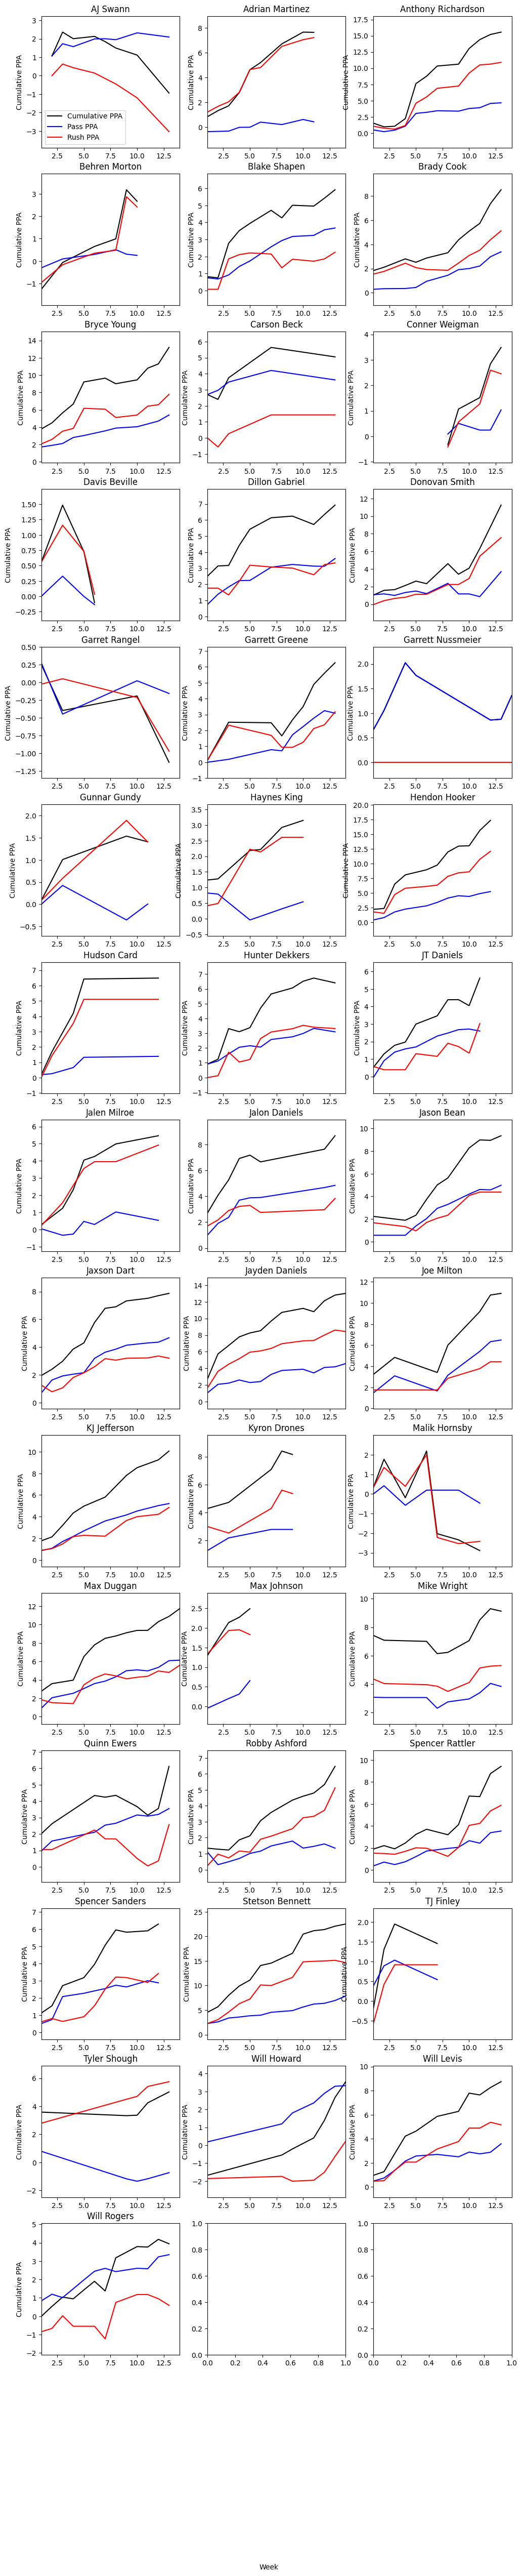

In [39]:
# Fetch PPA data for QBs in the selected teams
ppa_data = []

for team in teams:
    qb_ppa = player_game_stats_api.get_player_game_ppa(team=team, position='QB', year=2022)
    ppa_data.extend(qb_ppa)

# Convert PPA data to a DataFrame
ppa_df = pd.DataFrame.from_records(
    [dict(week=ppa.week,
          player_name=ppa.name,
          team=ppa.team,
          opponent=ppa.opponent,
          pass_ppa=ppa.average_ppa._pass,
          rush_ppa=ppa.average_ppa.rush) for ppa in ppa_data]
)

# Group data by player_name and week
grouped_data = ppa_df.groupby(['player_name', 'week']).sum().reset_index()

# Filter out players with less than four weeks of data
player_counts = grouped_data['player_name'].value_counts()
valid_players = player_counts[player_counts >= 4].index
grouped_data = grouped_data[grouped_data['player_name'].isin(valid_players)]

# Get unique player names
player_names = grouped_data['player_name'].unique()

# Calculate overall minimum and maximum week values
x_min = grouped_data['week'].min()
x_max = grouped_data['week'].max()

# Create the visualization
num_plots = len(player_names)
fig, axs = plt.subplots(num_plots // 3 + 1, 3, figsize=(12, 4 * (num_plots // 3 + 1)))

for idx, player_name in enumerate(player_names):
    player_data = grouped_data[grouped_data['player_name'] == player_name].copy()

    # Calculate the cumulative PPA
    player_data.loc[:, 'cumulative_pass_ppa'] = player_data['pass_ppa'].cumsum()
    player_data.loc[:, 'cumulative_rush_ppa'] = player_data['rush_ppa'].cumsum()
    player_data.loc[:, 'cumulative_ppa'] = player_data['cumulative_pass_ppa'] + player_data['cumulative_rush_ppa']

    # Plot cumulative PPA line
    axs[idx // 3, idx % 3].plot(player_data['week'], player_data['cumulative_ppa'], color='black', label='Cumulative PPA')

    # Plot pass and rush PPA lines
    axs[idx // 3, idx % 3].plot(player_data['week'], player_data['cumulative_pass_ppa'], color='blue', label='Pass PPA')
    axs[idx // 3, idx % 3].plot(player_data['week'], player_data['cumulative_rush_ppa'], color='red', label='Rush PPA')

    # Set axis labels and title
    axs[idx // 3, idx % 3].set_ylabel('Cumulative PPA')
    try:
        axs[idx // 3, idx % 3].set_title(f'{player_name} ({player_data["team"].iloc[0]})')
    except KeyError:
        axs[idx // 3, idx % 3].set_title(f'{player_name}')

    # Set the y-axis limits based on the data range
    y_min, y_max = axs[idx // 3, idx % 3].get_ylim()
    y_pad = 0.1 * (y_max - y_min)
    axs[idx // 3, idx % 3].set_ylim(y_min - y_pad, y_max + y_pad)
    
    # Set the x-axis limits based on the minimum and maximum values of the week column
    axs[idx // 3, idx % 3].set_xlim(x_min, x_max)

# Set common x-axis label
fig.text(0.5, 0.04, 'Week', ha='center', va='center')

# Add legend
axs[0, 0].legend()

# Display the visualization
plt.show()
